The Monte Carlo simulation is a probability model which generates random variables used in tandem with economic factors (expected return, volatility — in the case of a portfolio of funds) to predict outcomes over a large spectrum. While not the most accurate, the model is often used to calculate the risk and uncertainty.

We will now use the Monte Carlo simulation to generate a set of predicted returns for our portfolio of assets which will help us to find out the VaR of our investments.

In [ ]:
!pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 62 kB 1.3 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0


In [ ]:
#Importing all required libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pandas_datareader as web
from matplotlib.ticker import FuncFormatter
!pip install PyPortfolioOpt
#Installing the Portfolio Optimzation Library
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns
from matplotlib.ticker import FuncFormatter
from pandas_datareader import data as pdr
import yfinance as yf
import datetime as dt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 61 kB 3.1 MB/s 


#import data

In [ ]:
tickers = ['AAPL','MSFT', 'GOOGL', 'DIS']
thelen = len(tickers)

In [ ]:
df_stock = yf.download(tickers, start="2018-01-01", end=dt.date.today())['Close']

[*********************100%***********************]  4 of 4 completed


In [ ]:
df_stock

,AAPL,DIS,GOOGL,MSFT
Date,,,,
2018-01-02,43.064999,111.800003,53.660500,85.949997
2018-01-03,43.057499,112.279999,54.576000,86.349998
2018-01-04,43.257500,112.230003,54.787998,87.110001
2018-01-05,43.750000,111.620003,55.514500,88.190002
2018-01-08,43.587502,110.019997,55.710499,88.279999
...,...,...,...,...
2022-10-12,138.339996,93.410004,97.559998,225.750000
2022-10-13,142.990005,96.639999,99.059998,234.240005
2022-10-14,138.380005,94.449997,96.559998,228.559998


#calculated the portfolio weights of each asset using maximum sharpe ratio

In [ ]:
#annualized return
mu = expected_returns.mean_historical_return(df_stock)

In [ ]:
mu

AAPL     0.286157
DIS     -0.026138
GOOGL    0.140614
MSFT     0.237488
dtype: float64

In [ ]:
#sample variance of portfolio
Sigma = risk_models.sample_cov(df_stock)

In [ ]:
Sigma

,AAPL,DIS,GOOGL,MSFT
AAPL,0.109780,0.050713,0.070562,0.077992
DIS,0.050713,0.102158,0.052629,0.051825
GOOGL,0.070562,0.052629,0.094631,0.075366
MSFT,0.077992,0.051825,0.075366,0.093863


In [ ]:
#Max sharpe ratio - tangent to the EF
from pypfopt import objective_functions, base_optimizer
ef = EfficientFrontier(mu, Sigma, weight_bounds=(0,1)) #weight bounds in negative allows shorting of stocks

In [ ]:
sharpe_pfolio=ef.max_sharpe() 
#May use add objective to ensure minimum zero weighting to individual stocks
sharpe_pwt=ef.clean_weights()
print(sharpe_pwt)
sh_wt = list(sharpe_pwt.values())
sh_wt=np.array(sh_wt)

OrderedDict([('AAPL', 0.72008), ('DIS', 0.0), ('GOOGL', 0.0), ('MSFT', 0.27992)])


In [ ]:
sh_wt

array([0.72008, 0.     , 0.     , 0.27992])

#Convert stock prices to cumulative return

In [ ]:
ticker_rx2 = []
for a in range(thelen):
  ticker_rx = df_stock[[tickers[a]]].pct_change()
  ticker_rx = (ticker_rx+1).cumprod()
  ticker_rx2.append(ticker_rx[[tickers[a]]])
ticker_final = pd.concat(ticker_rx2,axis=1)
ticker_final

,AAPL,MSFT,GOOGL,DIS
Date,,,,
2018-01-02,NaN,NaN,NaN,NaN
2018-01-03,0.999826,1.004654,1.017061,1.004293
2018-01-04,1.004470,1.013496,1.021012,1.003846
2018-01-05,1.015906,1.026062,1.034551,0.998390
2018-01-08,1.012133,1.027109,1.038203,0.984079
...,...,...,...,...
2022-10-12,3.212353,2.626527,1.818097,0.835510
2022-10-13,3.320330,2.725306,1.846051,0.864401
2022-10-14,3.213282,2.659221,1.799461,0.844812


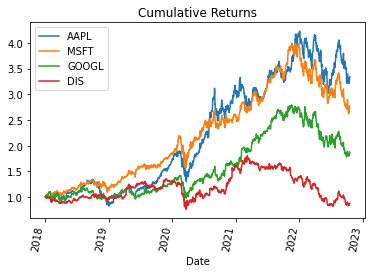

In [ ]:
#Plot graph of Cumulative/HPR of all stocks
for i, col in enumerate(ticker_final.columns):
  ticker_final[col].plot()
plt.title('Cumulative Returns')
plt.xticks(rotation=80)
plt.legend(ticker_final.columns)
#Saving the graph into a JPG file
plt.savefig('CR.png', bbox_inches='tight')

In [ ]:
#Taking Latest Values of Return
pret = []
pre1 = []
price =[]
for x in range(thelen):
  pret.append(ticker_final.iloc[[-1],[x]])
  price.append((df_stock.iloc[[-1],[x]]))
pre1 = pd.concat(pret,axis=1)
pre1 = np.array(pre1)
price = pd.concat(price,axis=1)
varsigma = pre1.std()
ex_rtn=pre1.dot(sh_wt)
print('The weighted expected portfolio return for selected time period is'+ str(ex_rtn))
#ex_rtn = (ex_rtn)**0.5-(1) #Annualizing the cumulative return (will not affect outcome)
price=price.dot(sh_wt) #Calculating weighted value


The weighted expected portfolio return for selected time period is[2.65018086]


In [41]:
print(ex_rtn[0], varsigma,price[0])

2.6501808598189003 0.9311358663603426 170.27242


#Monte carlo simulation

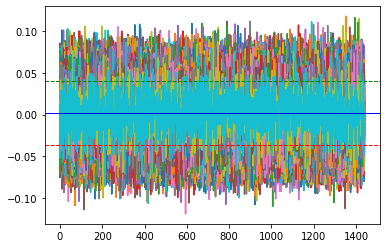

In [45]:
from scipy.stats import norm
import math
Time=1440 #No of days(steps or trading days in this case)
lt_price=[]
final_res=[]
for i in range(1000): #10000 runs of simulation
  daily_returns=(np.random.normal(ex_rtn/Time,varsigma/math.sqrt(Time),Time))
  plt.plot(daily_returns)
plt.axhline(np.percentile(daily_returns,5), color='r', linestyle='dashed', linewidth=1)
plt.axhline(np.percentile(daily_returns,95), color='g', linestyle='dashed', linewidth=1)
plt.axhline(np.mean(daily_returns), color='b', linestyle='solid', linewidth=1)
plt.show()



In [46]:
#Range of returns in a day of 1440 minutes | Red dash — Min Loss | Green Dash — Min Gain

In [47]:
#Visualizing the distribution plot of the returns presents us with the following chart

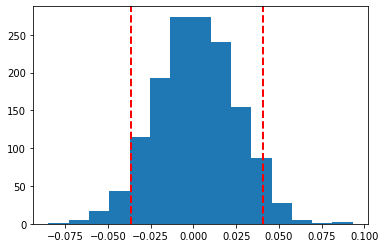

In [48]:
plt.hist(daily_returns,bins=15)
plt.axvline(np.percentile(daily_returns,5), color='r', linestyle='dashed', linewidth=2)
plt.axvline(np.percentile(daily_returns,95), color='r', linestyle='dashed', linewidth=2)
plt.show()

In [49]:
print(np.percentile(daily_returns,5),np.percentile(daily_returns,95)) #VaR - Minimum loss of 3.65% at a 5% probability, also a gain can be higher than 4.07% with a 5 % probability
pvalue = 1000 #portfolio value
print('$Amount required to cover minimum losses for one day is ' + str(pvalue* - np.percentile(daily_returns,5)))

-0.03650894598678639 0.04068665164552342
$Amount required to cover minimum losses for one day is 36.50894598678639
